In [1]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch
!pip3 install torchvision
!pip install Pillow==4.0.0
!pip install torchsummary
!pip install kornia
# %mkdir -p /content/csc420/a3/
# %cd /content/csc420/a3

     |████████████████████████████████| 5.6MB 2.6MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


     |████████████████████████████████| 122kB 2.8MB/s 


In [0]:
import os
from six.moves.urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
from PIL import Image

# MOUNT DATA

In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


# Read Data

In [0]:
import cv2
from pathlib import Path
import glob
from PIL import Image
import torch
from torchvision import datasets, transforms
import numpy as np
import pdb

train_input_path = glob.glob("./drive/My Drive/cat_data/Train/input/*.jpg")
train_input_path.sort()
train_mask_path = glob.glob("./drive/My Drive/cat_data/Train/mask/*.jpg")
train_mask_path.sort()

test_input_path = glob.glob("./drive/My Drive/cat_data/Test/input/*.jpg")
test_input_path.sort()
test_mask_path = glob.glob("./drive/My Drive/cat_data/Test/mask/*.jpg")
test_mask_path.sort()

train_inputs = []
train_masks = []
train_size = 0

test_inputs = []
test_masks = []
test_size = 0

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((128, 128)),
                                transforms.ToTensor()])

def augment_options(image, index):
    
    if index == 0:
        image = cv2.flip(image, 1)
        image = transform(image)
        
    if index == 1:
        image = np.uint8(np.clip((1.5 * image + 10), 0, 255))
        image = transform(image)
        
    if index == 2:
        (h,w) = image.shape[:2]
        center = (w / 2,h / 2)
        M = cv2.getRotationMatrix2D(center,30,1)
        image = cv2.warpAffine(image,M,(w,h))
        image = transform(image)
        
    if index == 3:
        M = np.float32([[1,0,25],[0,1,50]])
        image = cv2.warpAffine(image,M,(image.shape[1],image.shape[0]))
        image = transform(image)

    elif index != 0 or 1 or 2 or 3:
        image = transform(image)
               
    return image


def load_transform_dataset(input_path, mask_path, transform):
    images = []
    masks = []
    size = 0

    for imagepath in input_path:
        size = size + 1
        color_img = cv2.imread(str(imagepath))
        color_img = transform(color_img)
        images.append(color_img)

    for imagepath in mask_path:
        img = cv2.imread(str(imagepath))
        mask_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask_img = transform(mask_img)
        masks.append(mask_img)

    return images, masks, size

def load_dataset(input_path, mask_path):
    images = []
    masks = []
    size = 0

    for imagepath in input_path:
        size = size + 1
        color_img = cv2.imread(str(imagepath))
        images.append(color_img)

    for imagepath in mask_path:
        img = cv2.imread(str(imagepath))
        mask_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        masks.append(mask_img)

    return images, masks, size
    
    
class MyDataset:

    def __init__(self, inputs, masks, size):
        self.inputs = inputs
        self.masks = masks
        self.len = size

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.inputs[idx], self.masks[idx].float()

class MyAugmentDataset:

    def __init__(self, inputs, masks, size):
        self.inputs = inputs
        self.masks = masks
        self.len = size

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image = self.inputs[idx]
        mask = self.masks[idx]
        seed = np.random.randint(0, 999999)
        random_index = np.random.randint(0, 7)
#         print("random index = ", random_index)
        np.random.seed(seed)
        image = augment_options(image, random_index)
        np.random.seed(seed)
        mask = augment_options(mask, random_index)
        return image, mask.float()



In [0]:
train_inputs, train_thres, train_size = load_transform_dataset(train_input_path, train_mask_path, transform)
test_inputs, test_thres, test_size = load_transform_dataset(test_input_path, test_mask_path, transform)

train_data = MyDataset(train_inputs, train_thres, train_size)
test_data = MyDataset(test_inputs, test_thres, test_size)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

In [0]:
train_inputs, train_thres, train_size = load_dataset(train_input_path, train_mask_path)
test_inputs, test_thres, test_size = load_transform_dataset(test_input_path, test_mask_path, transform)

train_data = MyAugmentDataset(train_inputs + train_inputs, train_thres + train_thres, train_size + train_size)
test_data = MyDataset(test_inputs, test_thres, test_size)

augment_trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

# Visualization

train size =  60
test size =  21
torch.Size([4, 1, 128, 128])


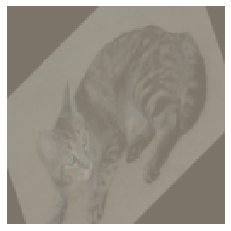

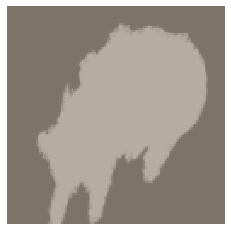

In [9]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from scipy import ndimage as nd
from matplotlib.patches import ConnectionPatch
import heapq
from PIL import Image

print("train size = ", train_size)
print("test size = ", test_size)

# cv2.imwrite("./test1.jpg", train_color_inputs[0])
# cv2.imwrite("./test2.jpg", train_inputs[0])
# cv2.imwrite("./test3.jpg", train_thres[0])
# cv2.imwrite("./test4.jpg", test_color_inputs[0])
# cv2.imwrite("./test5.jpg", test_inputs[0])
# cv2.imwrite("./test6.jpg", test_thres[0])

# img = Image.open("./test3.jpg")
# print(img.mode)
# img

dataiter = iter(augment_trainloader)
images, labels = dataiter.next()
print(labels.shape)
imshow(images[0])
imshow(labels[0])

# UNet

In [10]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from scipy import ndimage as nd
from matplotlib.patches import ConnectionPatch
import heapq
from PIL import Image
import argparse
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 
from torchsummary import summary
import pdb


class DoubleConv(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        
        super(DoubleConv,self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,3,padding=1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_ch),
            
            nn.Conv2d(out_ch,out_ch,3,padding=1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_ch)
            )
        
    def forward(self,x):
        return self.conv(x)
 
 
class UNet(nn.Module):
    
    def __init__(self,in_ch=3,out_ch=1):
        
        super(UNet,self).__init__()
        
        self.conv1 = DoubleConv(in_ch,64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = DoubleConv(64,128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = DoubleConv(128,256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.conv4 = DoubleConv(256,512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.conv5 = DoubleConv(512,1024)
        
        self.up6 = nn.ConvTranspose2d(1024,512,2,stride=2)
        self.conv6 = DoubleConv(1024,512)
        
        self.up7 = nn.ConvTranspose2d(512,256,2,stride=2)
        self.conv7 = DoubleConv(512,256)
        
        self.up8 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.conv8 = DoubleConv(256,128)
        
        self.up9 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.conv9 = DoubleConv(128,64)
        
        self.conv10 = nn.Conv2d(64,out_ch,1)
        
    
    def forward(self,x):
        
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        
        c5 = self.conv5(p4)
        
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6,c4],dim=1)
        c6 = self.conv6(merge6)
        
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7,c3],dim=1)
        c7 = self.conv7(merge7)
        
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8,c2],dim=1)
        c8 = self.conv8(merge8)
        
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9,c1],dim=1)
        c9 = self.conv9(merge9)
        
        c10 = self.conv10(c9)
        
        out = nn.Sigmoid()(c10)
        
        return out

        
model = UNet()
if torch.cuda.is_available():
    model.cuda()
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
       BatchNorm2d-3         [-1, 64, 128, 128]             128
            Conv2d-4         [-1, 64, 128, 128]          36,928
              ReLU-5         [-1, 64, 128, 128]               0
       BatchNorm2d-6         [-1, 64, 128, 128]             128
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
             ReLU-10          [-1, 128, 64, 64]               0
      BatchNorm2d-11          [-1, 128, 64, 64]             256
           Conv2d-12          [-1, 128, 64, 64]         147,584
             ReLU-13          [-1, 128, 64, 64]               0
      BatchNorm2d-14          [-1, 128,

# Dice Loss

In [0]:
class DiceLoss(nn.Module):
    
    def __init__(self):
        
        super(DiceLoss, self).__init__()

    def forward(self, input, target):

        smooth = 1.0

        iflat = input.view(-1)
        tflat = target.view(-1)
        
        iflat_square = iflat * iflat
        tflat_square = tflat * tflat
        
        intersection = (iflat * tflat).sum()
    
        return 1 - ( (2.0 * intersection + smooth) / (iflat_square.sum() + tflat_square.sum() + smooth) )
    

def CELoss(y, y_hat, cw):
    
    y, y_hat, cw = y.numpy(), y_hat.numpy(), cw.numpy()
    n, c, d1, d2 = y_hat.shape
    loss = np.empty_like(y)
    L=[]
    
    for i in range(n):
        for k in range(d1):
            for l in range(d2):
                clas = y[i,k,l]
                num = np.exp(y_hat[i,clas,k,l])
                denom = np.exp(y_hat[i,:,k,l]).sum()
                ce = -np.log(num/denom)*cw[clas]
                L.append(ce)
                
    loss = np.asarray(L).reshape(y.shape)
    
    return loss


# Loss Function

In [0]:
import torch.nn as nn

def loss_function(loss):
    if loss == 'bce':
        BCE_loss = nn.BCELoss()
        return BCE_loss
    elif loss == 'dice':
        dice_loss = DiceLoss()
        return dice_loss


# Training

In [0]:
import sys
import os
from optparse import OptionParser
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch import optim

from tqdm import tqdm

def train(net, trainloader, epochs=20, lr=0.003, loss_fun='dice'):

    if torch.cuda.is_available():
        net = net.cuda()
    
    criterion = loss_function(loss_fun)
    optimizer = torch.optim.Adam(net.parameters())
    result = []
    
    for e in range(epochs):
        net.train()
        running_loss = 0
        
        for images, labels in tqdm(trainloader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
                
            log_ps = net(images)
            loss = criterion(log_ps, labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            result.append([log_ps, images, labels])
            
        else:
            print(f"Training loss: {running_loss/len(trainloader)}")
            
    return result
  


# Testing

In [0]:
import sys
import os
from optparse import OptionParser
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

def test(net, testloader, loss_fun='dice'):

    net.eval()
    accuracy = 0
    result = []
    criterion = loss_function(loss_fun)
    
    for images, labels in testloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        log_ps = net(images)
        loss = criterion(log_ps, labels)
        
        accuracy += 1 - loss
        result.append([log_ps, images, labels])

    print("Test Accuracy: {:.3f}".format(accuracy / len(testloader)))

    return result

# Run

In [50]:
transfer_learning_net = UNet()
if torch.cuda.is_available():
    transfer_learning_net = transfer_learning_net.cuda()
    
transfer_learning_net.load_state_dict(torch.load("./drive/My Drive/csc420/my_net_3.pt"))
transfer_te_result = test(transfer_learning_net, testloader)

Test Accuracy: 0.911


In [42]:
net = UNet()

if torch.cuda.is_available():
    net = net.cuda()

train(net, trainloader)
normal_te_result = test(net, testloader)

  0%|          | 0/15 [00:00<?, ?it/s]

Training loss: 0.3616743922233582


  0%|          | 0/15 [00:00<?, ?it/s]

Training loss: 0.32314998706181847


  0%|          | 0/15 [00:00<?, ?it/s]

Training loss: 0.26556370258331297


  0%|          | 0/15 [00:00<?, ?it/s]

Training loss: 0.2352707068125407


  0%|          | 0/15 [00:00<?, ?it/s]

Training loss: 0.2460876742998759


  0%|          | 0/15 [00:00<?, ?it/s]

Training loss: 0.22407633066177368


  0%|          | 0/15 [00:00<?, ?it/s]

Training loss: 0.22416775226593016


  0%|          | 0/15 [00:00<?, ?it/s]

Training loss: 0.22270710865656534


  0%|          | 0/15 [00:00<?, ?it/s]

Training loss: 0.20345031817754108


100%|██████████| 15/15 [00:03<00:00,  4.43it/s]


Training loss: 0.20759664376576742
Test Accuracy: 0.742


In [47]:
net = UNet()

if torch.cuda.is_available():
    net = net.cuda()

train(net, augment_trainloader)
augment_te_result = test(net, testloader)

  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.3142541885375977


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.27955378691355387


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.2403293232123057


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.21050145427385966


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.1998043954372406


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.19437562227249144


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.19244557817776997


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.18175169428189594


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.18566314975420634


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.1840334117412567


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.1813755730787913


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.17532446185747783


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.1791789750258128


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.1667296330134074


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.1727011521657308


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.16509188214937845


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.1606819768746694


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.15293065110842388


  0%|          | 0/30 [00:00<?, ?it/s]

Training loss: 0.1563935418923696


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


Training loss: 0.16156862179438272
Test Accuracy: 0.798


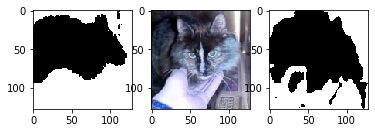

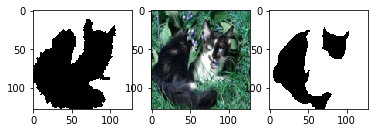

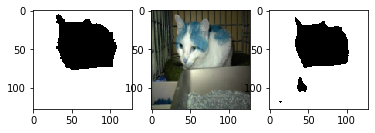

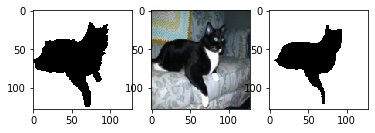

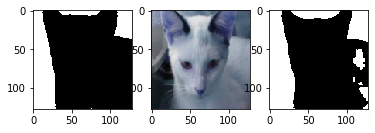

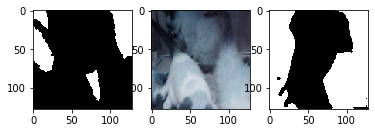

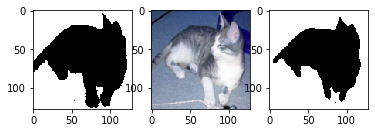

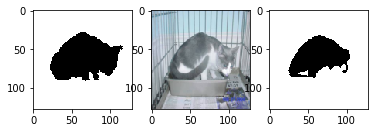

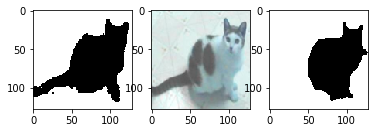

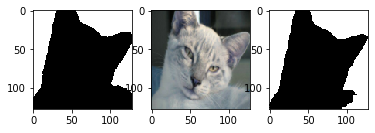

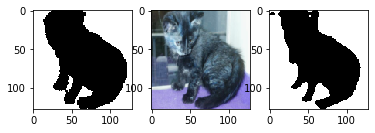

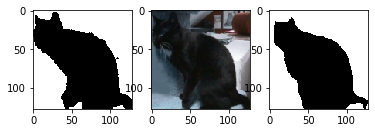

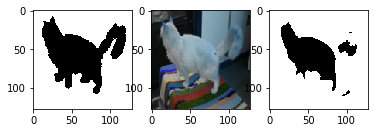

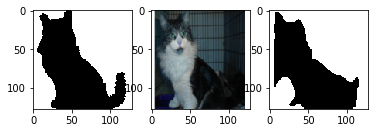

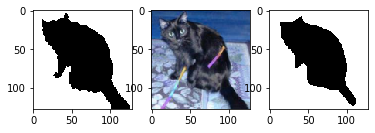

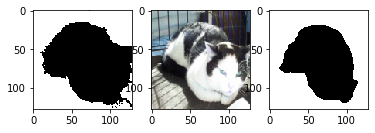

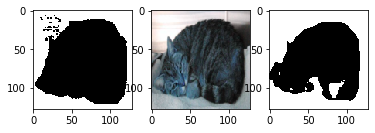

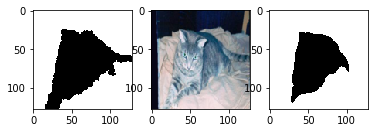

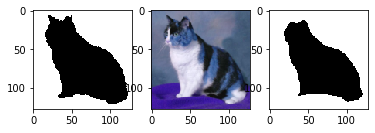

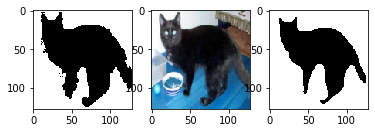

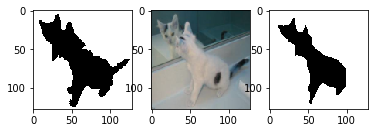

In [51]:
import matplotlib.pyplot as plt

# dataiter = iter(testloader)
# images, labels = dataiter.next()
# print(labels.shape)
# imshow(images[0])
# imshow(labels[0])

def view_result(result, index):

    ret, binary_mask = cv2.threshold(result[index][2].cpu().squeeze().numpy(),0.05,1,0)
    ret, binary_pred = cv2.threshold(result[index][0].cpu().squeeze().detach().numpy(),0.5,1,0)
    plt.subplot(1,3,1)
    plt.imshow(binary_mask,cmap=plt.cm.binary)
    plt.subplot(1,3,2)
    plt.imshow(result[index][1].cpu().squeeze().permute(1,2,0))
    plt.subplot(1,3,3)
    plt.imshow(binary_pred,cmap=plt.cm.binary)
    plt.show()

for i in range(len(transfer_te_result)):
    view_result(transfer_te_result, i)


# Visualizing Prediction

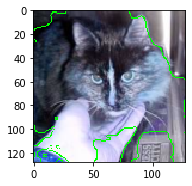

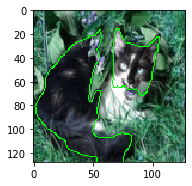

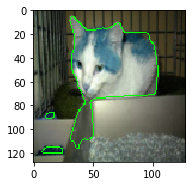

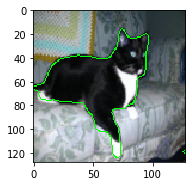

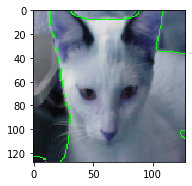

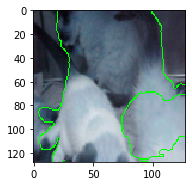

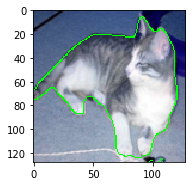

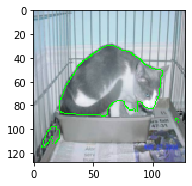

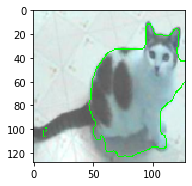

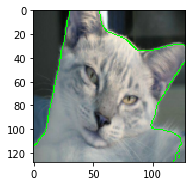

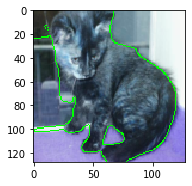

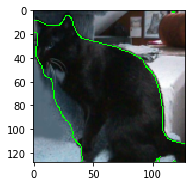

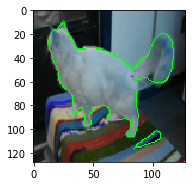

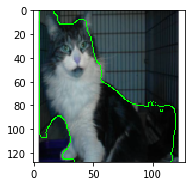

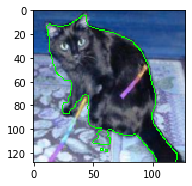

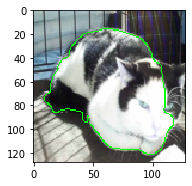

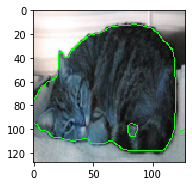

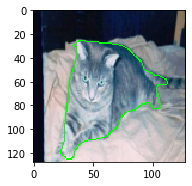

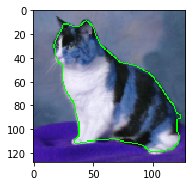

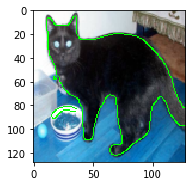

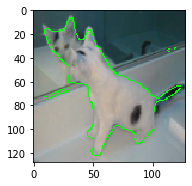

<Figure size 432x288 with 0 Axes>

In [52]:
def visualize(result, index):
    ret, binary_pred = cv2.threshold(result[index][0].cpu().squeeze().detach().numpy(),0.05,1,0)
    outputs = np.array(binary_pred)*255
    images = np.array(result[index][1].cpu().squeeze().permute(1,2,0))

    result = np.copy(images)
    outputs_canny = cv2.Canny(np.uint8(outputs), 20, 250)
    result[outputs_canny == 255] = [0,1,0]
    plt.subplot(1, 2, 1)
    plt.imshow(result)
    plt.show()
    plt.tight_layout()

for i in range(len(transfer_te_result)):
    visualize(transfer_te_result, i)